Steane code encoding fault tolerance
=============================== 

1. Set up two logical zero for Steane code based  on the parity matrix in the book by Nielsen MA, Chuang IL. Quantum Computation and Quantum Information, 10th Anniversary Edition. Cambridge University Press; 2016. p. 474

2. Set up fault tolerance as per scheme B and C from Goto H. Minimizing resource overheads for fault-tolerant preparation of encoded states of the Steane code. Sci Rep. 2016 Jan 27;6:19578. 

3. Compare this with the non fault tolerant encoding circuit and a single qubit.

3. Find out if either scheme have a tolerance.

Import the necessary function modules, including the SteaneCodeLogicalQubit class.  The methods of this class are called in this notebook.

In [1]:
from qiskit import(
    QuantumCircuit,
    QuantumRegister,
    ClassicalRegister,
    execute,
    Aer
    )

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

from circuits import SteaneCodeLogicalQubit

from helper_functions import (
    get_noise, 
    mean_of_list,
    calculate_standard_error,
    print_time,
    process_FT_results
    )

import matplotlib.pyplot as plt

Define constants so the process flow can be controlled from one place:

In [2]:
SINGLE_GATE_ERRORS = ['x', 'y', 'z', 'h', 's', 'sdg']
TWO_GATE_ERRORS = ['cx', 'cz']

NOISE = True                             #Test with noise
SHOTS = 100000                           #Number of shots to run 
SHOTS_SINGLE = 1000000                   #Number of shots to run 
MEASURE_NOISE = 0.0046                   #Measurement noise not relevant
SINGLE_GATE_DEPOLARISING = 0.000366      #Single gate noise   
TWO_GATE_DEPOLARISING = 0.0204
FACTOR_LIST = [1, 0.1, 0.01, 0.001, 0.0001]
ITERATIONS = 25
SIMULATOR = Aer.get_backend('qasm_simulator')
TITLE = 'Steane code encoding'

We specify the parity check matrix, since this defines the Steane code.  It is validated before the logical qubit is initiated to check that it is orthogonal to the valid codewords.

In [3]:
parity_check_matrix = ['0001111',
                       '0110011',
                       '1010101'
                      ]

In [4]:
codewords = ['0000000',
             '1010101',
             '0110011',
             '1100110',
             '0001111',
             '1011010',
             '0111100',
             '1101001'
            ]

Function module for non fault tolerant decoding circuit.

In [5]:
def encoding():
    # normal fault tolerance
    qubit = SteaneCodeLogicalQubit(1, parity_check_matrix, codewords, ancilla = False)
    qubit.set_up_logical_zero(0)
    qubit.logical_measure_data(0)
    if NOISE:
        result = execute(qubit, SIMULATOR, noise_model = noise_model, shots = SHOTS).result()
    else:
        result = execute(qubit, SIMULATOR, shots = SHOTS).result()
    counts = result.get_counts(qubit)
    #print(counts)
    return(counts)

In [6]:
def single_qubit():
    cd = QuantumRegister(1,'data')
    sd = ClassicalRegister(1,'measure_data') 
    qc = QuantumCircuit(cd, sd)
    qc.measure(cd, sd)
    if NOISE:
        result = execute(qc, SIMULATOR, noise_model = noise_model, shots = SHOTS_SINGLE).result()
    else:
        result = execute(qc, SIMULATOR, shots = SHOTS_SINGLE).result()
    counts = result.get_counts(qc)
    return(counts)

Function module for non fault tolerant decoding circuit, scheme b from Goto's paper.  See worksheet 
"Steane_code_encoding_FTb" for circuit diagram

In [7]:
def encoding_FTb():
    qubit = SteaneCodeLogicalQubit(2, parity_check_matrix, codewords, 
                                   ancilla = False, fault_tolerant_b = True, 
                                   data_rounds = 3
                                  )
    qubit.set_up_logical_zero(0)
    for i in range(3):
        qubit.barrier()
        qubit.set_up_logical_zero(1)
        qubit.barrier()
        qubit.logical_gate_CX(0, 1)
        qubit.barrier()
        qubit.logical_measure_data(logical_qubit = 1, measure_round = i + 1)
        qubit.barrier() 
    qubit.logical_measure_data(0)
    if NOISE:
        result = execute(qubit, SIMULATOR, noise_model = noise_model, shots = SHOTS).result()
    else:
        result = execute(qubit, SIMULATOR, shots = SHOTS).result()
    counts = result.get_counts(qubit)
    return(counts)

Function module for non fault tolerant decoding circuit, scheme c from Goto's paper.  See worksheet 
"Steane_code_encoding_FTc" for circuit diagram

In [8]:
def encoding_FTc():
    qubit_list = [2,4,5]
    qubit = SteaneCodeLogicalQubit(1, parity_check_matrix, codewords, ancilla = False, 
                                   fault_tolerant_c = True, data_rounds = 3,                )
    qubit.set_up_logical_zero(0)
    qubit.barrier()
    qubit.barrier()
    for i in range(3):
        qubit.encode_fault_tolerant_method_C(qubit_list)
        qubit.barrier()
        qubit.logical_measure_data(0, i + 1)
        qubit.barrier()
    qubit.barrier() 
    if NOISE:
        result = execute(qubit, SIMULATOR, noise_model = noise_model, shots = SHOTS).result()
    else:
        result = execute(qubit, SIMULATOR, shots=SHOTS).result()
    counts = result.get_counts(qubit)
    #print(counts)
    return(counts)

In [9]:
single = []
nonft = []
ftb = []
ftc = []
error_single = []
error_ftb = []
error_ftc = []
error_nonft = []
for factor in FACTOR_LIST:
    print()
    print_time()
    print(f'Processing factor {factor}')
    if NOISE:
        noise_model = get_noise(MEASURE_NOISE * factor, SINGLE_GATE_DEPOLARISING * factor, 
                                TWO_GATE_DEPOLARISING * factor, SINGLE_GATE_ERRORS, TWO_GATE_ERRORS
                               )
        
    print('Processing single qubit')
    results_list = []
    for iteration in range(ITERATIONS):
        counts = single_qubit()
        error_rate, rejected, accepted, valid, invalid = process_FT_results(counts, '0', 'S')
        results_list.append(error_rate)
    mean = mean_of_list(results_list)
    standard_deviation, standard_error = calculate_standard_error(results_list)
    print(f'The mean is {mean:.6f}, the standard error is {standard_error:.6f}')
    print(f'The standard devation is {standard_deviation:.6f}')
    single.append(mean)
    error_single.append(standard_error)
    print()
    
    print('Processing FTb')
    results_list = []
    for iteration in range(ITERATIONS):
        #print(f'Processing iteration {iteration}')
        counts = encoding_FTb()
        #print ('The different states can be counted.  The simulated result are', counts)
        error_rate, rejected, accepted, valid, invalid = process_FT_results(counts, codewords, 'B')
        #print(f'The error rate is {error_rate:.4f} ')
        results_list.append(error_rate)
        #print()
    mean = mean_of_list(results_list)
    standard_deviation, standard_error = calculate_standard_error(results_list)
    print(f'The mean is {mean:.6f}, the standard error is {standard_error:.6f}')
    print(f'The standard devation is {standard_deviation:.6f}')
    ftb.append(mean)
    error_ftb.append(standard_error)
    print()
    
    print('Processing FTc')
    results_list = []
    for iteration in range(ITERATIONS):
        #print(f'Processing iteration {iteration}')
        counts = encoding_FTc()
        #print ('The different states can be counted.  The simulated result are', counts)
        error_rate, rejected, accepted, valid, invalid = process_FT_results(counts, codewords, 'C')
        #print(f'The error rate is {error_rate:.4f} ')
        results_list.append(error_rate)
        #print()
    mean = mean_of_list(results_list)
    standard_deviation, standard_error = calculate_standard_error(results_list)
    print(f'The mean is {mean:.6f}, the standard error is {standard_error:.6f}')
    print(f'The standard devation is {standard_deviation:.6f}')
    ftc.append(mean)
    error_ftc.append(standard_error)
    print()
    
    print('process non FT circuit')
    results_list = []
    for iteration in range(ITERATIONS):
        #print(f'Processing iteration {iteration}')
        counts = encoding()
        #print ('The different states can be counted.  The simulated result are', counts)
        error_rate, rejected, accepted, valid, invalid = process_FT_results(counts, codewords, 'N')
        #print(f'The error rate is {error_rate:.4f} ')
        results_list.append(error_rate)
        #print()
    mean = mean_of_list(results_list)
    standard_deviation, standard_error = calculate_standard_error(results_list)
    print(f'The mean is {mean:.6f}, the standard error is {standard_error:.6f}')
    print(f'The standard devations {standard_deviation:.6f}')
    nonft.append(mean)
    error_nonft.append(standard_error)



Current Time = 22:18:55
Processing factor 1
Processing single qubit
The mean is 0.004608, the standard error is 0.000012
The standard devation is 0.000061

Processing FTb
The mean is 0.100953, the standard error is 0.000354
The standard devation is 0.001772

Processing FTc
The mean is 0.121794, the standard error is 0.000252
The standard devation is 0.001258

process non FT circuit
The mean is 0.176796, the standard error is 0.000275
The standard devations 0.001377

Current Time = 22:36:12
Processing factor 0.1
Processing single qubit
The mean is 0.000455, the standard error is 0.000003
The standard devation is 0.000016

Processing FTb
The mean is 0.010312, the standard error is 0.000056
The standard devation is 0.000281

Processing FTc
The mean is 0.012295, the standard error is 0.000086
The standard devation is 0.000429

process non FT circuit
The mean is 0.019456, the standard error is 0.000077
The standard devations 0.000383

Current Time = 22:53:02
Processing factor 0.01
Processi

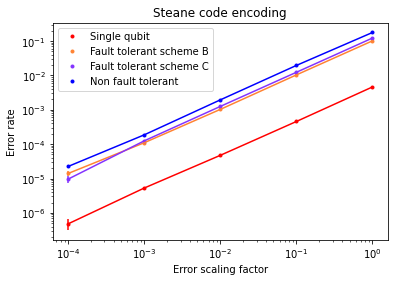

In [10]:
plt.plot(FACTOR_LIST, single, '.',color = 'red', linestyle = '', label = 'Single qubit')
plt.plot(FACTOR_LIST, ftb, '.',color = '#ff8333', linestyle = '', label = 'Fault tolerant scheme B')
plt.plot(FACTOR_LIST, ftc, '.',color = '#8333ff', linestyle = '', label = 'Fault tolerant scheme C')
plt.plot(FACTOR_LIST, nonft, '.',color = 'blue', linestyle = '', label = 'Non fault tolerant')
plt.errorbar(FACTOR_LIST, single, yerr = error_single, color = 'red' )   
plt.errorbar(FACTOR_LIST, ftb, yerr = error_ftb, color = '#ff8333' )
plt.errorbar(FACTOR_LIST, ftc, yerr = error_ftc, color = '#8333ff' )
plt.errorbar(FACTOR_LIST, nonft, yerr = error_nonft, color = 'blue' )
plt.xlabel('Error scaling factor')
plt.ylabel('Error rate')
plt.title(TITLE)
plt.xscale("log")
plt.yscale("log")
plt.legend()

fname = TITLE + '.png'
plt.savefig(fname)